In [1]:
!pip install emcee
!pip install corner==2.2.0
import numpy as np
import pandas as pd
import pickle
import emcee
import corner
import os
from matplotlib import pyplot as plt

In [2]:
## saving figures in the figures folder
repo_path = "../../figures/"

In [3]:
current_directory = os.getcwd()
filename = 'optical_clocks_keys.pkl'

file_path = os.path.join(current_directory, filename)

In [4]:
with open(file_path, 'rb') as f:
    optical_clocks_dictionary = pickle.load(f)
df_d = pd.DataFrame()
columns = ['d', 'u', 'MJD End']

for key, df in optical_clocks_dictionary.items():
    df_d = pd.concat([df_d, df[columns]])

perih_2017=57757 # perihelion in 2017 in MJD
t_meas=np.array(df_d['MJD End']) # in days
t_meas=t_meas-perih_2017
y_meas=np.array(df_d['d'])
sigma_y_meas=np.array(df_d['u'])

In [5]:
def emcee_sampler(log_post, x0, nburn=300, steps=10000, **kwargs):
    """

    This function is a parallelized sampler that makes use of emcee
    (https://emcee.readthedocs.io/en/stable/)

    """

    mnwalkers, mndim = x0.shape

    sampler = emcee.EnsembleSampler(mnwalkers,
                                    mndim,
                                    log_post)
    sampler.run_mcmc(x0, nburn, progress=True,tune=True)
    state = sampler.get_chain()[-1, :, :]
    sampler.reset()
    print(
        'Finished initial run, burn-in dropped and starting real run')
    sampler.run_mcmc(state, steps, progress=True,tune=True)

    return sampler.get_log_prob(), sampler.get_chain()

def big_sampler(x,y,sigma_y,theoretical_waveform, theta0, log_prior=lambda _:0.0, nburn=300, steps=3000):

    def log_posterior(theta):
        res=(y-theoretical_waveform(x,theta))/sigma_y
        return -np.sum(res**2)/2-0.5*np.sum(2*np.pi*sigma_y) + log_prior(theta)

    ndim=len(theta0)
    nwalkers=8*ndim
    p0=np.zeros((nwalkers,ndim))
    for i in range(nwalkers):
        p0[i]=theta0*np.random.normal(loc=1.0, scale=0.01, size=ndim)


    return emcee_sampler(log_posterior, p0, nburn=nburn, steps=steps)

## Modified Gravity (A)


In [6]:
def h_gravity(t,pars):
    A= pars
    return A*np.sin(2*np.pi*t/365.26) # +offs

def my_priors(pars):
    A= pars
    if A <-1e-14 or A >1e-14:
        return -np.inf
    return 0.

p0=np.array([1e-17]) # initial guess

pdf_and_chain=big_sampler(t_meas,y_meas,sigma_y_meas,h_gravity,p0, log_prior=my_priors,steps=3000)

chains=pdf_and_chain[1]

100%|██████████| 300/300 [00:00<00:00, 2378.70it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 3000/3000 [00:00<00:00, 3351.57it/s]


In [7]:
samples=chains.reshape(-1,chains.shape[-1])

In [8]:
# Posterior mean and median
mean_A = np.mean(samples)
median_A = np.median(samples)
variance_A = np.var(samples)
sigma_A = np.std(samples)

## upper and lower bound at confidence interval = 2-sigma
lower_bound = mean_A - 2*sigma_A
upper_bound = mean_A + 2*sigma_A

print(f"Posterior mean: {mean_A}")#
print(f"Posterior median: {median_A}")
print(f"Posterior variance: {variance_A}")
print(f"Posterior variance: {sigma_A}")
print(f"95% credible interval: [{lower_bound}, {upper_bound}]")

Posterior mean: -5.031039788091984e-17
Posterior median: -5.139334115944895e-17
Posterior variance: 1.8674970473042654e-33
Posterior variance: 4.3214546709461913e-17
95% credible interval: [-1.3673949129984366e-16, 3.6118695538003984e-17]


In [9]:
sigma_A
with open("MG_A_sigma.txt", "w") as f:
    f.write(str(sigma_A))

In [10]:
print(mean_A - sigma_A)
print(mean_A + sigma_A)

-9.352494459038176e-17
-7.095851171457929e-18


In [11]:
print(samples.shape)

(24000, 1)


y(t)=A*sin(2pi*t/1yr)+c
1


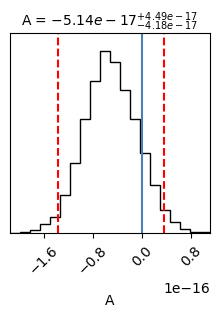

In [12]:
print('y(t)=A*sin(2pi*t/1yr)+c')
fig = corner.corner(samples, labels=["A"], show_titles=True, truths=[0.0],title_fmt = '.2e', title_kwargs={"fontsize": 10}) # truths=np.array([0.,0.])
print(len(fig.axes))
   
ax = fig.axes[0]

   
ax.vlines(lower_bound, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='red', linestyle='--', label='1-sigma contour')
ax.vlines(upper_bound, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='red', linestyle='--')
#plt.savefig('sine_fit.png', dpi=300)
plt.savefig(os.path.join(repo_path, "sine_fit_MCMC.pdf"), bbox_inches='tight')

## Dark Energy - linear

In [13]:
def h_linear(t,pars):
    a= pars
    return a*t

def my_priors(pars):
    a= pars
    if a <-1e-17 or a >1e-17:
        return -np.inf
    return 0.

p0=np.array([1e-19]) # initial guess

pdf_and_chain=big_sampler(t_meas,y_meas,sigma_y_meas,h_linear,p0, log_prior=my_priors,steps=3000)

chains=pdf_and_chain[1]

100%|██████████| 300/300 [00:00<00:00, 2293.24it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 3000/3000 [00:00<00:00, 3706.33it/s]


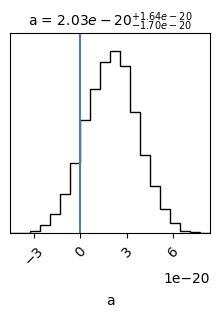

In [14]:
samples=chains.reshape(-1,chains.shape[-1])
my_figure = corner.corner(samples, labels=["a"], show_titles=True,truths=np.array([0.]),title_fmt = '.2e', title_kwargs={"fontsize": 10}) # ,truths=myhps

plt.show()

In [15]:
mean_a=np.mean(samples[:,0])
print(mean_a)

2.0149459398055914e-20


In [16]:
sigma_A_DE = np.std(samples)
sigma_A_DE

np.float64(1.6799356838497975e-20)

In [17]:
with open("DE_A_sigma.txt", "w") as f:
    f.write(str(sigma_A_DE))

In [18]:
 #confidence_interval = 0.95
lower_bound_a = mean_a - 2*sigma_A_DE
upper_bound_a = mean_a + 2*sigma_A_DE

In [19]:
print(upper_bound_a)

5.3748173075051864e-20


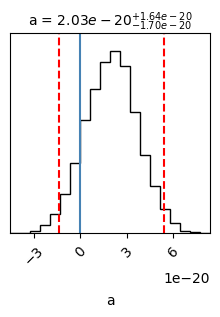

In [20]:
my_figure = corner.corner(samples, labels=["a"], show_titles=True, truths=[0], title_fmt = '.2e', title_kwargs={"fontsize": 10})
plt.axvline(lower_bound_a, color='red', linestyle='--', label='1-sigma contour')
plt.axvline(upper_bound_a, color='red', linestyle='--')
#plt.text(upper_bound_a, 0, f' {upper_bound_a:.2e}', color='red', verticalalignment='bottom', horizontalalignment='right')

# Additional step to save the figure without a background
#plt.savefig('linear_fit.pdf', dpi=300,transparent=True, bbox_inches='tight', pad_inches=0)
#plt.savefig('linear_fit.png', dpi=300)
plt.savefig(os.path.join(repo_path, "linear_fit_MCMC.pdf"), bbox_inches='tight')

## Dark Matter

In [21]:
def h_dmatter(t,pars):
    A, omega, phi= pars
    return A/omega*np.sin(omega*t+phi)

T = 365.26
w = 2*np.pi


def my_priors(pars):
    A, omega, phi= pars
    if (A/omega) < -1e-14 or (A/omega) >1e-14 or phi< -np.pi or phi > np.pi or omega < w/(4*T) or omega > w/15:# or A < -1e-1 or A > 1e-10:# or A < -1e-10 or A > 1e-10: #omega < -3*w or omega >3*w
        return -np.inf
    return 0.

p0=np.array([1e-16,w/T, 0.1])
pdf_and_chain=big_sampler(t_meas,y_meas,sigma_y_meas,h_dmatter,p0, log_prior=my_priors,steps=30000)

chains=pdf_and_chain[1]

100%|██████████| 300/300 [00:00<00:00, 1584.03it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 30000/30000 [00:17<00:00, 1703.15it/s]


In [22]:
(2*np.pi)/(10)

0.6283185307179586

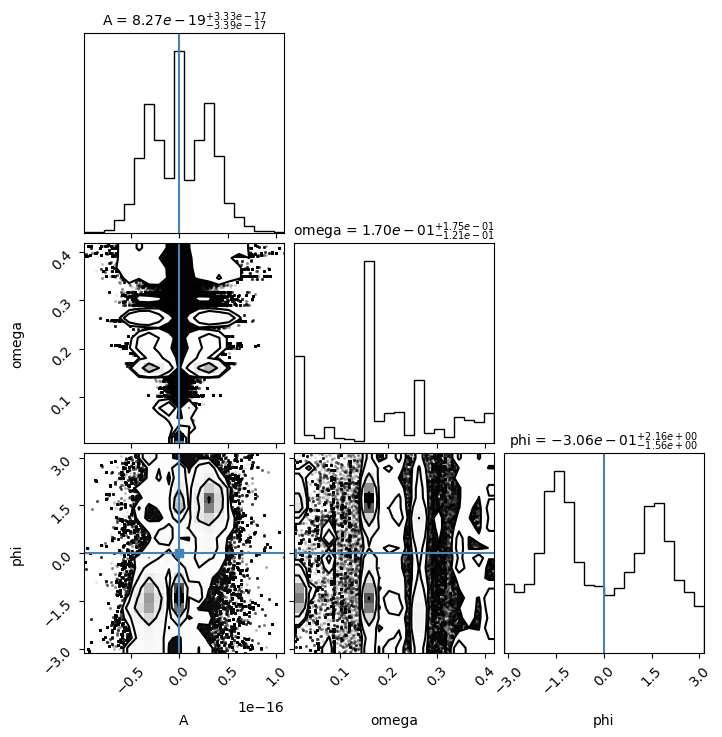

In [23]:
samples=chains.reshape(-1,chains.shape[-1])
my_figure = corner.corner(samples, labels=["A", "omega","phi"], show_titles=True,truths=np.array([0., 0.,0.]),title_fmt = '.2e', title_kwargs={"fontsize": 10}) # ,truths=myhps
plt.savefig(os.path.join(repo_path, "DM_MCMC.pdf"), bbox_inches='tight')

In [24]:
A_samples = samples[:, 0]
sigma_A_DM = np.std(A_samples)
print(sigma_A_DM)

with open("DM_A_sigma.txt", "w") as f:
    f.write(str(sigma_A_DM))

3.1049723977502364e-17
